## 初始化

### 调包

In [2]:
import sys
import os
import time
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm import tqdm
import camb
from camb import model, initialpower
import warnings 
warnings.filterwarnings('ignore')
sys.path.append("/home/chenzy/code/")
import illustris_python as il
import h5py
from scipy.spatial import KDTree
from IA_func import *

In [3]:
def plot_histogram(ax, x, y, bins, c="k", label="", alpha=1):
    mean,edge=np.histogram(x,bins=bins,weights=y)
    N,edge=np.histogram(x,bins=bins)
    ax.plot((edge[1:]+edge[:-1])/2,mean/N,c, label=label, alpha=alpha)
    #ax.plot((edge[1:]+edge[:-1])/2,-mean/N,c+":", alpha=alpha)
def turn_label_tick(label_ticks, imshow_ticks):
#label_ticks, 在哪些地方放标签
#imshow_ticks, 0，1，2.。。。对应的值
    y=interpolate.interp1d(imshow_ticks, np.arange(len(imshow_ticks))-0.5)

    label_str=["%.1f" % number for number in label_ticks]
    
    return y(label_ticks), label_str

def plot_v_r_2d_hist_N(ax, r_bins, v_bins, r, v, vmax=3, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )

    image = ax.imshow(np.log10(N/(4*np.pi*(r_edge[1:]/2+r_edge[:-1]/2)**2)), origin="lower",vmax=vmax, vmin=vmin)
    
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('np.log10(n)')
    
    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=(r_edge[1:]+r_edge[:-1])/2)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=(v_edge[1:]+v_edge[:-1])/2)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
    return np.log10(N/(4*np.pi*(r_edge[1:]/2+r_edge[:-1]/2)**2))
def plot_v_r_2d_hist_q(ax, r_bins, v_bins, r, v, q, vmax=0.8, vmin=0.6, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000], clabel = "q=b/a"):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[ v_bins, r_bins], )
    q_mean,v_edge, r_edge=np.histogram2d(v, r, bins=[v_bins, r_bins], weights=q)
    q_mean=q_mean/N
    
    image=ax.imshow(q_mean, origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label(clabel) 

    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)
def plot_v_r_2d_hist_cos(ax, r_bins, v_bins, r, v, cos, vmax=0.8, vmin=0.6, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[-1000,-100,0,100,1000]):
    N, v_edge, r_edge=np.histogram2d(v, r, bins=[v_bins, r_bins], )
    cos_mean,v_edge, r_edge=np.histogram2d(v, r, bins=[v_bins, r_bins], weights=cos**2-1/3.)
    cos_mean=cos_mean/N
    
    image=ax.imshow((cos_mean), origin="lower",vmax=vmax, vmin=vmin)
    cb=plt.colorbar(image, ax=ax)
    cb.set_label('|cos^2|-1/3') 

    label_loc_r, label_str_r=turn_label_tick(label_ticks=r_ticks, imshow_ticks=r_bins)
    ax.set_xticks(label_loc_r)
    ax.set_xticklabels(label_str_r)
    ax.set_xlabel(xlabel)
    label_loc_v, label_str_v=turn_label_tick(label_ticks=v_ticks, imshow_ticks=v_bins)
    ax.set_yticks(label_loc_v)
    ax.set_yticklabels(label_str_v)
    ax.set_ylabel(ylabel)

### 常数定义

In [10]:
basePath_tng100="/home/cossim/IllustrisTNG/TNG100-1/"
particle_dm_mass=0.00050557*10**10
boxlen_100=75000 #ckpc/h
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

### 读数据

In [11]:
#Halos
#Group中第一个subhalo对应的坐标
GroupFirstSub=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupFirstSub")
#Group的坐标 ckpc/h
GroupPos=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupPos")
#Group的速度 km/s/a
GroupVel=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="GroupVel")
#mass 200   10^10 M_sun/h
Group_M_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_M_Mean200")
# R mean 200 ckpc/h
Group_R_Mean200=il.groupcat.loadHalos(basePath=basePath_tng100, snapNum=99, fields="Group_R_Mean200")



In [24]:
#subhalo
#subhalo的坐标 ckpc/h
SubhaloPos=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloPos")
#subhalo是否可靠
SubhaloFlag=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloFlag")
#subhalo 的速度 km/s
SubhaloVel=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloVel")
# all mass
SubhaloMass=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMass")
# mass type
SubhaloMassType=il.groupcat.loadSubhalos(basePath=basePath_tng100, snapNum=99, fields="SubhaloMassType")
SubhaloMass_Star=SubhaloMassType[:,4]

#offset file
f = h5py.File("/home/cossim/IllustrisTNG/TNG100-1/postprocessing/offsets/offsets_099.hdf5", "r")
pid_group=f["Group/SnapByType"][:]
pid_subhalo=f["Subhalo/SnapByType"][:]
parttype_id={"gas":0,"dm":1,"star":4}


## offset file 

In [4]:

# 在halo粒子表中， subhalo的粒子label
def get_pid_group_subhalo(subgroup_id, group_id, parttype="dm"):
    
    return [pid_subhalo[subgroup_id,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]],
            pid_subhalo[subgroup_id+1,parttype_id[parttype]]-pid_group[group_id,parttype_id[parttype]]]
#对于一个group获得其subhalo的ID
def get_subhaloID(GroupID):
    if GroupFirstSub[GroupID]==-1:
        return 0
    return np.arange(GroupFirstSub[GroupID],GroupFirstSub[GroupID+1])


# halo mass function

190
569
1694


Text(0, 0.5, 'N')

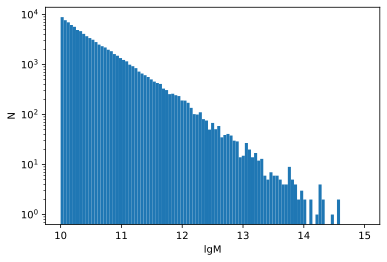

In [5]:
plt.hist(np.log10(Group_M_Mean200)+10, bins = np.linspace(10,15,100))
plt.yscale("log")
print(len(np.where(Group_M_Mean200>10**3)[0]))
print(len(np.where(Group_M_Mean200>10**2.5)[0]))
print(len(np.where(Group_M_Mean200>10**2)[0]))
plt.xlabel("lgM")
plt.ylabel("N")

# velocity profile

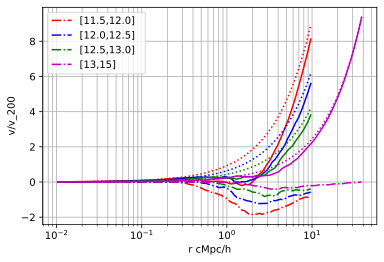

In [22]:
H0 = 100 #km/s/(Mpc/h)
lgM_min=13
lgM_max=15
c = ["r", "b", "g", "m", ]
ci = 0

for lgM_min, lgM_max in [[11.5, 12.0], [12.0, 12.5], [12.5, 13.0], [13, 15]]:
    group_id_label=np.where((Group_M_Mean200>10**(lgM_min-10))&(Group_M_Mean200<10**(lgM_max-10)))[0]
    v_200=2.076*10**2*np.sqrt(Group_M_Mean200[group_id_label]/Group_R_Mean200[group_id_label])
    d=np.load("/home/chenzy/data/ia_vel/v_profile_"+str(lgM_min)+"_"+str(lgM_max)+".npz")
    r = d["r"]
    v_pro = d["v_pro"]
    v_H = r*H0/np.mean(v_200)
    plt.plot(r, v_pro, c[ci]+"-.",label="["+str(lgM_min)+","+str(lgM_max)+"]  ")
    plt.plot(r, v_H, c[ci]+":")
    plt.plot(r, v_pro+v_H, c[ci])
    
    
    ci+=1
    
    
plt.xscale("log")
plt.grid(which="both")
#plt.xlim(10**-1, 10**1)
plt.xlabel("r cMpc/h")
plt.ylabel("v/v_200")
plt.legend()
#plt.ylim(-0.4, 0.1)

100%|██████████| 3177/3177 [1:17:25<00:00,  1.46s/it]


Text(0, 0.5, 'V/V_200')

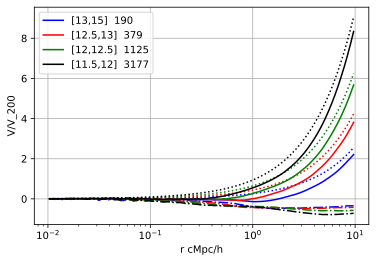

In [45]:
def get_stack_vel_profile(lgM_min,lgM_max,boxlen=boxlen_100, lgr_min=-2, lgr_max=1, N_bin_r=100):
    group_id_label=np.where((Group_M_Mean200>10**(lgM_min-10))&(Group_M_Mean200<10**(lgM_max-10)))[0]
    N_group=len(group_id_label)
    
    r_bin=10**np.linspace(lgr_min, lgr_max, N_bin_r)
    vel_stack=np.zeros(len(r_bin)-1)
    vel_H=np.zeros(len(r_bin)-1)
    for group_id in tqdm(group_id_label):
        group_pos=GroupPos[group_id,:]
        v_200=2.076*10**2*np.sqrt(Group_M_Mean200[group_id]/Group_R_Mean200[group_id])  #km/s

        r_subgroup_group=get_pos_diff(pos_a=group_pos,pos_b=SubhaloPos,boxlen=boxlen)/1000 #Mpc/h
        r_len=np.sqrt(r_subgroup_group[:,0]**2+r_subgroup_group[:,1]**2+r_subgroup_group[:,2]**2)  #Mpc/h


        vel_subgroup_group=SubhaloVel-GroupVel[group_id,:]
        vel_r_subgroup_group=np.sum(r_subgroup_group*vel_subgroup_group, axis=1)/r_len
        vel_r_subgroup_group[np.where(r_len==0)]=0 # the group itself is also in the subgroup catalog and need to be excluded
    
        vel_r_mean, edge=np.histogram(r_len, bins=r_bin, weights=vel_r_subgroup_group)
        r=(edge[1:]+edge[:-1])/2
        N, edge=np.histogram(r_len, bins=r_bin)
        vel_r_mean[np.where(N>0)]/=N[np.where(N>0)]
        vel_stack+=vel_r_mean/v_200
        vel_H+=r*100/v_200
        
    vel_stack/=N_group
    vel_H/=N_group
    
    return r, vel_stack, vel_H, N_group   
def draw_stack_vel_profile(ax, c, lgM_min,lgM_max,boxlen=boxlen_100, lgr_min=-2, lgr_max=1, N_bin_r=100):
    
    r, vel_stack, vel_H, N_group = get_stack_vel_profile(lgM_min=lgM_min,lgM_max=lgM_max,boxlen=boxlen, lgr_min=lgr_min, lgr_max=lgr_max, N_bin_r=N_bin_r)

    ax.plot(r, vel_stack, "-.", c=c)
    ax.plot(r, vel_H, ":", c=c)
    ax.plot(r, vel_H+vel_stack, c=c, label="["+str(lgM_min)+","+str(lgM_max)+"]  "+str(N_group))
    
fig,ax=plt.subplots()
draw_stack_vel_profile(ax=ax, c="b", lgM_min=13,lgM_max=15)
draw_stack_vel_profile(ax=ax, c="r", lgM_min=12.5,lgM_max=13)
draw_stack_vel_profile(ax=ax, c="g", lgM_min=12,lgM_max=12.5)
draw_stack_vel_profile(ax=ax, c="k", lgM_min=11.5,lgM_max=12)
ax.legend()
ax.grid()
ax.set_xscale("log")
ax.set_xlabel("r cMpc/h")
ax.set_ylabel("V/V_200")

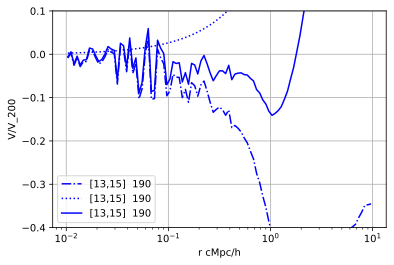

In [44]:
ax.set_ylim(-0.4,0.1)
fig

# q, v_para - r

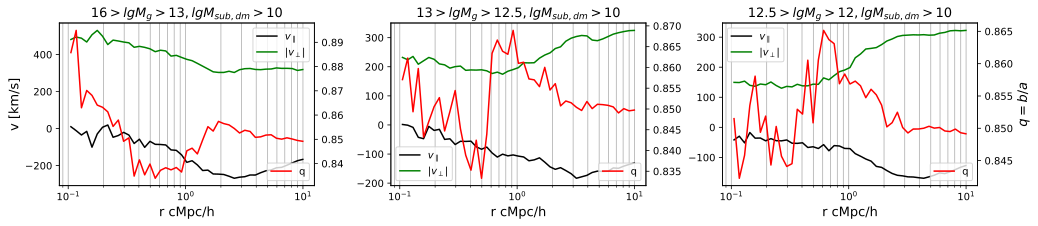

In [38]:
(M_200, r_200, v_200, M_sub, r_len, v_len, v_para, v_perp, q, cos_A_r, cos_v_r, cos_v_A) = np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99.npy")

fig, axr = plt.subplots(1, 3, figsize = (3*5.5, 3), gridspec_kw = {'wspace':0.3})
lgMs = [16, 13, 12.5, 12]

for i in range(len(lgMs)-1):
    ax = axr[i]
    label = np.where((M_200>10**lgMs[i+1]/10**10)&(M_200<10**lgMs[i]/10**10))[0]

   
    plot_histogram(ax=ax, x=r_len[label], y=v_para[label], bins=10**np.linspace(-1,1.2), c="k", label=r"$v_\parallel$", alpha=1)
    plot_histogram(ax=ax, x=r_len[label], y=v_perp[label], bins=10**np.linspace(-1,1.2), c="g", label=r"$|v_\perp|$",alpha=1)
    ax2 = ax.twinx()
    plot_histogram(ax=ax2, x=r_len[label], y=q[label], bins=10**np.linspace(-1,1.2), c="r",label="q", alpha=1)
    ax.set_xscale("log")
    ax.set_xlabel(r"r cMpc/h", font = {"size": 13})
    if i == 0:
        ax.set_ylabel(r"v [km/s]", font = {"size": 13})
    if i == 2:
        ax2.set_ylabel(r"$q = b/a$", font = {"size": 13})
    ax.set_title(r"$"+str(lgMs[i])+">lgM_g>"+str(lgMs[i+1])+", lgM_{sub,dm}>10$", font = {"size": 13})
    ax.legend()
    ax2.legend(loc=4)
    ax.grid(axis='x', which='both')

44275
72531
187188


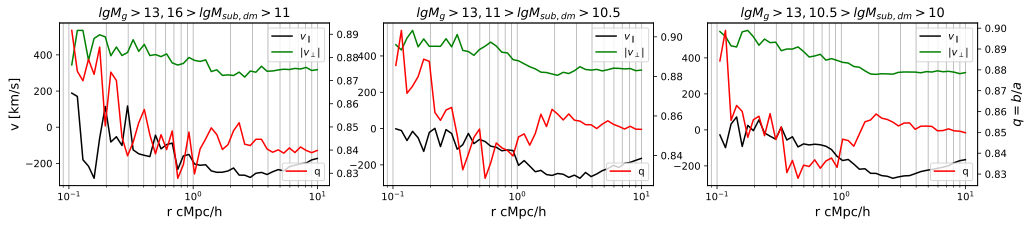

In [37]:
(M_200, r_200, v_200,M_sub, r_len, v_len, v_para, v_perp, q, cos_A_r, cos_v_r, cos_v_A) = np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99.npy")

fig, axr = plt.subplots(1, 3, figsize = (3*5.5, 3))
lgMsubs = [16, 11, 10.5, 10]

for i in range(len(lgMsubs)-1):
    ax = axr[i]
    label = np.where((M_200>10**13/10**10)&
                    (M_sub>10**lgMsubs[i+1]/10**10)&(M_sub<10**lgMsubs[i]/10**10))[0]
    print(len(label))

   
    plot_histogram(ax=ax, x=r_len[label], y=v_para[label], bins=10**np.linspace(-1,1.2), c="k", label=r"$v_\parallel$", alpha=1)
    plot_histogram(ax=ax, x=r_len[label], y=v_perp[label], bins=10**np.linspace(-1,1.2), c="g", label=r"$|v_\perp|$",alpha=1)
    ax2 = ax.twinx()
    plot_histogram(ax=ax2, x=r_len[label], y=q[label], bins=10**np.linspace(-1,1.2), c="r",label="q", alpha=1)
    ax.set_xscale("log")
    ax.set_xlabel(r"r cMpc/h", font = {"size": 13})
    if i == 0:
        ax.set_ylabel(r"v [km/s]", font = {"size": 13})
    if i == 2:
        ax2.set_ylabel(r"$q = b/a$", font = {"size": 13})
    
    ax.set_title(r"$lgM_g>13, "+str(lgMsubs[i])+">lgM_{sub,dm}>"+str(lgMsubs[i+1])+"$", font = {"size": 13})
    ax.legend()
    ax2.legend(loc=4)
    ax.grid(axis='x', which='both')

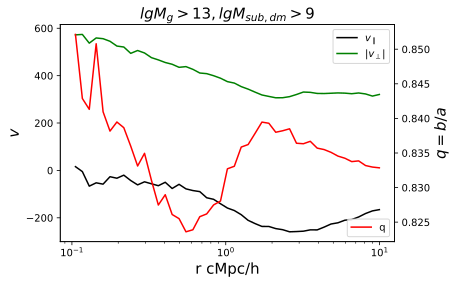

In [25]:

#print(np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99_1.npy"))
(M_200, r_200, v, M_sub, r_len, v_len, v_para, v_perp, q, cos_A_r, cos_v_r, cos_v_A) = np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99_1.npy")

label = np.where(M_200>10**13/10**10)[0]

fig, ax =plt.subplots()
plot_histogram(ax=ax, x=r_len[label], y=v_para[label], bins=10**np.linspace(-1,1.2), c="k", label=r"$v_\parallel$", alpha=1)
plot_histogram(ax=ax, x=r_len[label], y=v_perp[label], bins=10**np.linspace(-1,1.2), c="g", label=r"$|v_\perp|$",alpha=1)
ax2 = ax.twinx()
plot_histogram(ax=ax2, x=r_len[label], y=q[label], bins=10**np.linspace(-1,1.2), c="r",label="q", alpha=1)
ax.set_xscale("log")
ax.set_xlabel(r"r cMpc/h", font = {"size": 15})
ax.set_ylabel(r"$v$", font = {"size": 15})
ax2.set_ylabel(r"$q = b/a$", font = {"size": 15})
ax.set_title(r"$lgM_g>13, lgM_{sub,dm}>9$", font = {"size": 15})
ax.legend()
ax2.legend(loc=4)

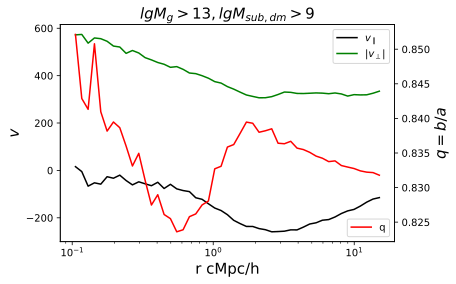

In [170]:
(M_200, r_200, M_sub, r_len, v_len, v_para, v_perp, q, cos_A_r, cos_v_r, cos_v_A) = np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99.npy")

label = np.where(M_200>10**13/10**10)[0]

fig, ax =plt.subplots()
plot_histogram(ax=ax, x=r_len[label], y=v_para[label], bins=10**np.linspace(-1,1.2), c="k", label=r"$v_\parallel$", alpha=1)
plot_histogram(ax=ax, x=r_len[label], y=v_perp[label], bins=10**np.linspace(-1,1.2), c="g", label=r"$|v_\perp|$",alpha=1)
ax2 = ax.twinx()
plot_histogram(ax=ax2, x=r_len[label], y=q[label], bins=10**np.linspace(-1,1.2), c="r",label="q", alpha=1)
ax.set_xscale("log")
ax.set_xlabel(r"r cMpc/h", font = {"size": 15})
ax.set_ylabel(r"$v$", font = {"size": 15})
ax2.set_ylabel(r"$q = b/a$", font = {"size": 15})
ax.set_title(r"$lgM_g>13, lgM_{sub,dm}>9$", font = {"size": 15})
ax.legend()
ax2.legend(loc=4)

In [ ]:
(M_200, r_200, M_sub, r_len, v_len, v_para, v_perp, q, cos_A_r, cos_v_r, cos_v_A) = np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99.npy")

label = np.where(M_200>10**13/10**10)[0]

fig, ax =plt.subplots()
plot_histogram(ax=ax, x=r_len[label], y=v_para[label], bins=10**np.linspace(-1,1.2), c="k", label=r"$v_\parallel$", alpha=1)
plot_histogram(ax=ax, x=r_len[label], y=v_perp[label], bins=10**np.linspace(-1,1.2), c="g", label=r"$|v_\perp|$",alpha=1)
ax2 = ax.twinx()
plot_histogram(ax=ax2, x=r_len[label], y=cos_v_r[label]**2-1/3., bins=10**np.linspace(-1,1.2), c="r",label="q", alpha=1)
ax.set_xscale("log")
ax.set_xlabel(r"r cMpc/h", font = {"size": 15})
ax.set_ylabel(r"$v$", font = {"size": 15})
ax2.set_ylabel(r"$q = b/a$", font = {"size": 15})
ax.set_title(r"$lgM_g>13, lgM_{sub,dm}>9$", font = {"size": 15})
ax.legend()
ax2.legend(loc=4)

303994 0.7663985638623347
528819 0.4169706040243881
1507748 0.2816082914636877


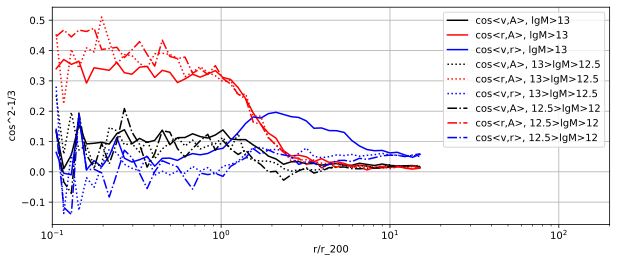

In [94]:
fig, ax =plt.subplots(figsize =(10, 4))
label = np.where(M_200>10**13/10**10)[0]
label1 = np.where(M_200>10**13/10**10)[0]
label2 = np.where((M_200>10**12.5/10**10)&(M_200<10**13/10**10))[0]
label3 = np.where((M_200>10**12/10**10)&(M_200<10**12.5/10**10))[0]
ls = ["-", ":", "-."]
labels = ["lgM>13", "13>lgM>12.5", "12.5>lgM>12"]
i=0
for label in [label1, label2, label3]:
    print(len(label), np.mean(r_200[label]))
    plot_histogram(ax=ax, x=(r_len/r_200)[label], y=cos_v_A[label]**2-1/3, bins=10**np.linspace(-1,1.2), c="k"+ls[i], label=r"cos<v,A>, "+labels[i], alpha=1)
    plot_histogram(ax=ax, x=(r_len/r_200)[label], y=cos_A_r[label]**2-1/3, bins=10**np.linspace(-1,1.2), c="r"+ls[i], label=r"cos<r,A>, "+labels[i], alpha=1)
    plot_histogram(ax=ax, x=(r_len/r_200)[label], y=cos_v_r[label]**2-1/3, bins=10**np.linspace(-1,1.2), c="b"+ls[i], label=r"cos<v,r>, "+labels[i], alpha=1)
    ax.set_xscale("log")
    i+=1
ax.set_xlabel("r/r_200")
ax.set_ylabel("cos^2-1/3")
ax.set_xlim(0.1,200)
ax.legend()
ax.grid()

# 2d hist v-r

113350161 113350161


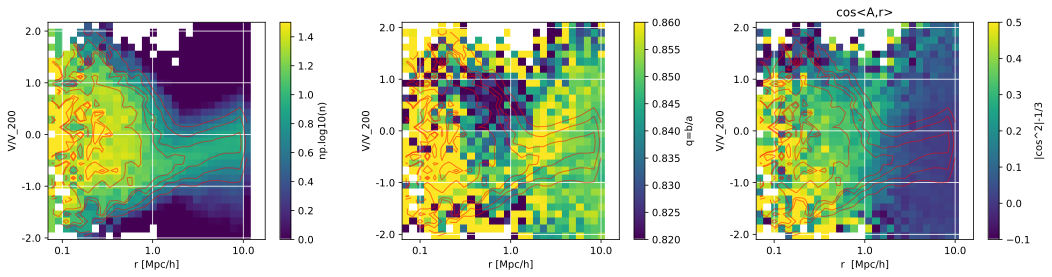

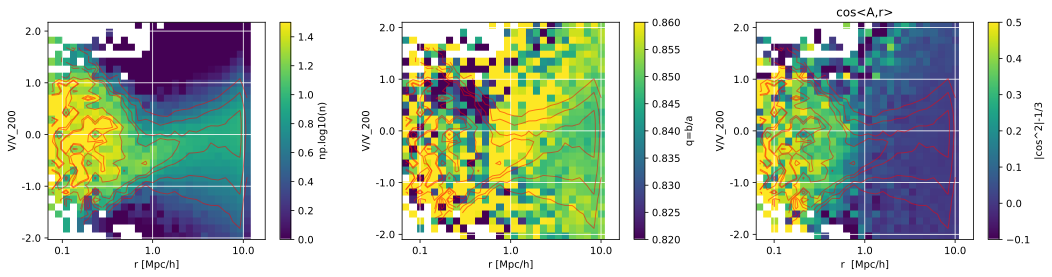

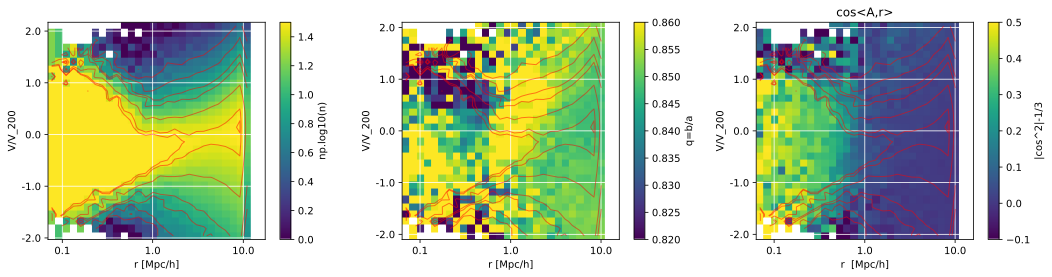

In [124]:
(M_200, r_200, v_200,M_sub, r_len, v_len, v_para, v_perp, q, cos_A_r, cos_v_r, cos_v_A) = np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99.npy")
 
n_bin = 31

label1 = np.where(M_200>10**13/10**10)[0]
label2 = np.where((M_200>10**12.5/10**10)&(M_200<10**13/10**10))[0]
label3 = np.where((M_200>10**12/10**10)&(M_200<10**13.5/10**10))[0]
#print(len(label), np.mean(r_200[label]))
for label in [label1, label2, label3]:
    fig, ax = plt.subplots(1, 3, figsize = (3*6, 4), )
    N_image = plot_v_r_2d_hist_N(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-2.1, 2.1, n_bin), r=r_len[label], v=v_para[label]/v_200[label], vmax=1.5, vmin=0, xlabel="r [Mpc/h]", ylabel="V/V_200", r_ticks=[0.1,1,10], v_ticks=[-2, -1, 0, 1, 2])

    plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-2.1,2.1,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=q[label], vmax=0.86, vmin=0.82, xlabel="r [Mpc/h]", ylabel="V/V_200", r_ticks=[0.1, 1,10], v_ticks=[-2, -1, 0, 1, 2])

    plot_v_r_2d_hist_cos(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-2.1, 2.1, n_bin), r=r_len[label], v=v_para[label]/v_200[label], cos=cos_A_r[label], vmax=0.5, vmin=-0.1, xlabel="r  [Mpc/h]", ylabel="V/V_200",  r_ticks=[0.1, 1,10], v_ticks=[-2, -1, 0, 1, 2])
    #plot_v_r_2d_hist_cos(ax=ax[3], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3, 3, n_bin), r=r_len[label], v=v_para[label]/v_200[label], cos=cos_v_A[label], vmax=0.5, vmin=-0.1, xlabel="r/r_200", ylabel="V km/s",  r_ticks=[0.1, 1,10], v_ticks=[-2, -1, 0, 1, 2])

    ax[2].set_title("cos<A,r>")
    #ax[2].set_title("cos<A,v>")
    for i in [0,1,2]:
        ax[i].grid(c='w')
        ax[i].contour(N_image, [ 0.5,0.7,0.9, 1, 1.25,1.45, 1.5], colors='r', linewidths=1, alpha=0.5)
    #break

113350161 0.08580604379144119


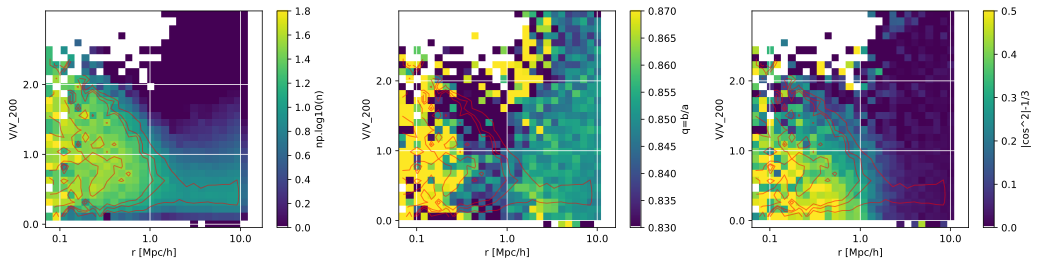

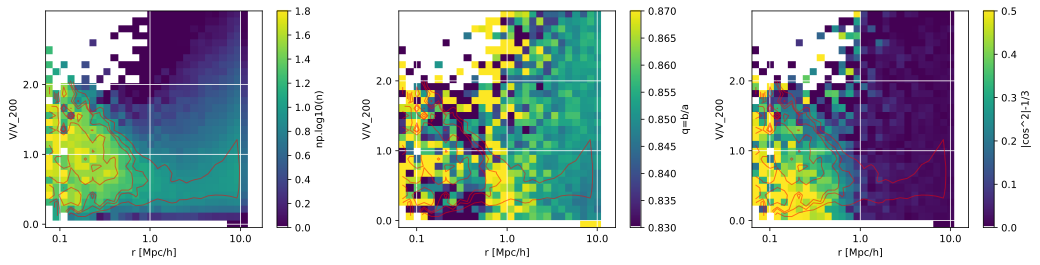

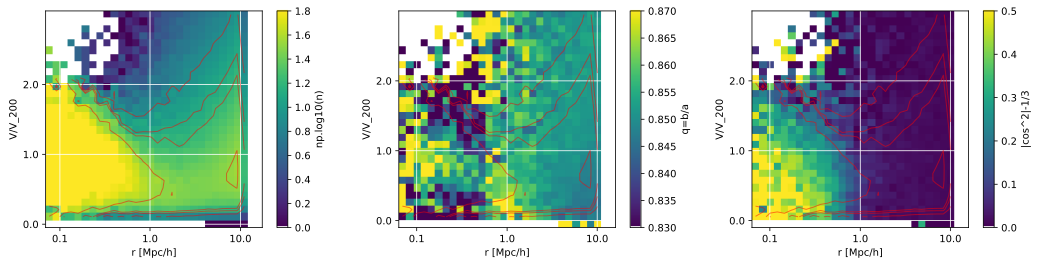

In [125]:
#fig, ax = plt.subplots(1, 3, figsize = (3*6, 4), )
n_bin = 31
label = np.where(M_200>10**1/10**10)[0]
#(M_200, r_200, v_200, M_sub, r_len, v_len, v_para, v_perp, q, cos_A_r, cos_v_r, cos_v_A) = np.load("/home/chenzy/data/ia_vel/quality_3d_dm_99.npy")

label1 = np.where(M_200>10**13/10**10)[0]
label2 = np.where((M_200>10**12.5/10**10)&(M_200<10**13/10**10))[0]
label3 = np.where((M_200>10**12/10**10)&(M_200<10**13.5/10**10))[0]
print(len(label), np.mean(r_200[label]))
for label in [label1, label2, label3]:
    fig, ax = plt.subplots(1, 3, figsize = (3*6, 4), )
    N_image = plot_v_r_2d_hist_N(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-0.1, 3,n_bin), r=r_len[label], v=v_perp[label]/v_200[label], vmax=1.8, vmin=0, xlabel="r [Mpc/h]", ylabel="V/V_200", r_ticks=[0.1,1,10], v_ticks=[0, 1, 2])

    plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-0.1,3,n_bin), r=r_len[label], v=v_perp[label]/v_200[label], q=q[label], vmax=0.87, vmin=0.83, xlabel="r [Mpc/h]", ylabel="V/V_200", r_ticks=[0.1,1,10], v_ticks=[0, 1, 2])

    plot_v_r_2d_hist_cos(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-0.1, 3,n_bin), r=r_len[label], v=v_perp[label]/v_200[label], cos=cos_A_r[label], vmax=0.5, vmin=0, xlabel="r [Mpc/h]", ylabel="V/V_200",  r_ticks=[0.1,1,10], v_ticks=[0, 1, 2])

    #plot_v_r_2d_hist_cos(ax=ax[3], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-0.1, 3,n_bin), r=r_len[label], v=v_perp[label]/v_200[label], cos=cos_v_A[label], vmax=0.5, vmin=0, xlabel="r/r_200", ylabel="V km/s",  r_ticks=[0.1,1,10], v_ticks=[0, 1, 2])
    for i in [0,1,2]:
        ax[i].grid(c='w')
        ax[i].contour(N_image, [ 0.9,1.1,1.2,1.5], colors='r', linewidths=1, alpha=0.5)
    #break

# e

In [126]:
proj = 'x'
(M_200x, r_200x, v_200x, M_subx, r_lenx, v_lenx, v_parax, v_perpx, e1x, e2x) = np.load("/home/chenzy/data/ia_vel/quality_2d_"+proj+"_pt_star_99.npy",
                                                                            allow_pickle=True)
proj = 'y'
(M_200y, r_200y, v_200y, M_suby, r_leny, v_leny, v_paray, v_perpy, e1y, e2y) = np.load("/home/chenzy/data/ia_vel/quality_2d_"+proj+"_pt_star_99.npy",
                                                                            allow_pickle=True)
proj = 'z'
(M_200z, r_200z, v_200z, M_subz, r_lenz, v_lenz, v_paraz, v_perpz, e1z, e2z) = np.load("/home/chenzy/data/ia_vel/quality_2d_"+proj+"_pt_star_99.npy",
                                                                            allow_pickle=True)

M_200 = np.hstack([ M_200x, M_200y, M_200z])
r_200 = np.hstack([ r_200x, r_200y, r_200z])
v_200 = np.hstack([ v_200x, v_200y, v_200z])
M_sub = np.hstack([ M_subx, M_suby, M_subz])
r_len = np.hstack([ r_lenx, r_leny, r_lenz])
v_len = np.hstack([ v_lenx, v_leny, v_lenz])
v_para = np.hstack([ v_parax, v_paray, v_paraz])
v_perp = np.hstack([ v_perpx, v_perpy, v_perpz])
e1 = np.hstack([e1x, e1y, e1z])
e2 = np.hstack([e2x, e2y, e2z])

e_len = np.sqrt(e1**2+e2**2)


In [50]:
np.mean(e1), np.mean(e2)

(0.29697792649296945, 0.00024102707710994055)

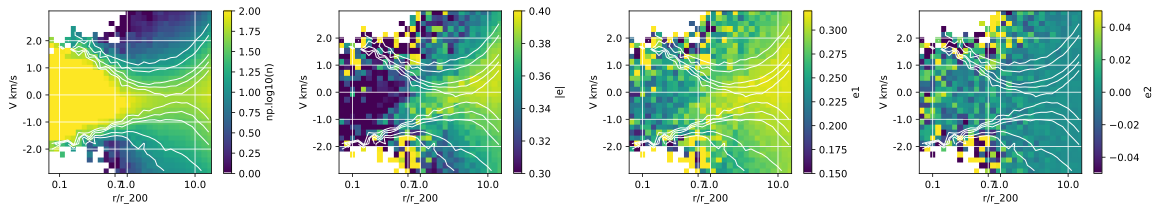

In [133]:
fig, ax = plt.subplots(1, 4, figsize = (4*5, 3), )
label = np.where(M_200>10**12/10**10)[0]
n_bin = 31
N_image = plot_v_r_2d_hist_N(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-3, 3, n_bin), r=r_len[label], v=v_para[label]/v_200[label], vmax=2, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])

plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e_len[label], vmax=0.4, vmin=0.3, xlabel="r/r_200", ylabel="V km/s",clabel="|e|", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e1[label], vmax=0.32, vmin=0.15, xlabel="r/r_200", ylabel="V km/s", clabel="e1",r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[3], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e2[label], vmax=0.05, vmin=-0.05, xlabel="r/r_200", ylabel="V km/s",clabel="e2", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
for i in [0,1,2,3]:
    ax[i].grid(c='w')
    ax[i].contour(N_image, [ 1, 1.2, 1.5, 1.6, 1.7], colors='w', linewidths=1)

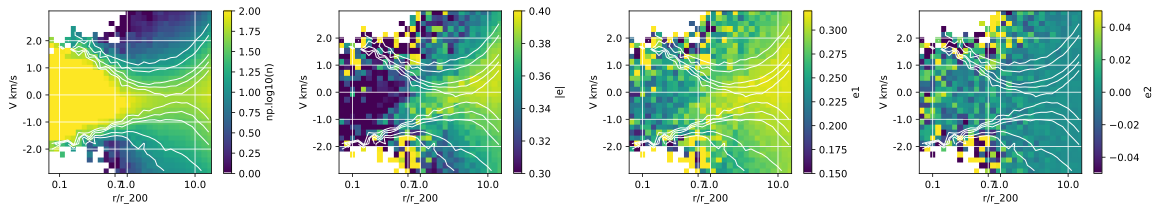

In [144]:
fig, ax = plt.subplots(1, 4, figsize = (4*5, 3), )
label = np.where(M_200>10**12/10**10)[0]
n_bin = 31
N_image = plot_v_r_2d_hist_N(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-3, 3, n_bin), r=r_len[label], v=v_para[label]/v_200[label], vmax=2, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])

plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e_len[label], vmax=0.4, vmin=0.3, xlabel="r/r_200", ylabel="V km/s",clabel="|e|", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e1[label], vmax=0.32, vmin=0.15, xlabel="r/r_200", ylabel="V km/s", clabel="e1",r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[3], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e2[label], vmax=0.05, vmin=-0.05, xlabel="r/r_200", ylabel="V km/s",clabel="e2", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
for i in [0,1,2,3]:
    ax[i].grid(c='w')
    ax[i].contour(N_image, [ 1, 1.2, 1.5, 1.6, 1.7], colors='w', linewidths=1)

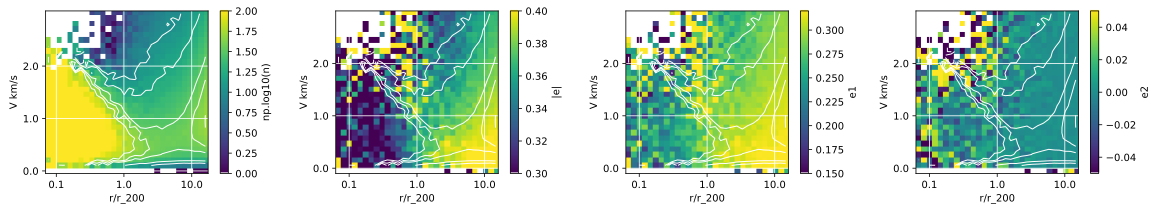

In [136]:
fig, ax = plt.subplots(1, 4, figsize = (4*5, 3), )
label = np.where(M_200>10**12/10**10)[0]
n_bin = 31
N_image = plot_v_r_2d_hist_N(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2,n_bin), v_bins=np.linspace(-0.1, 3, n_bin), r=r_len[label], v=v_perp[label]/v_200[label], vmax=2, vmin=0, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1,1,10], v_ticks=[ 0, 1, 2])

plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-0.1,3,n_bin), r=r_len[label], v=v_perp[label]/v_200[label], q=e_len[label], vmax=0.4, vmin=0.3, xlabel="r/r_200", ylabel="V km/s",clabel="|e|", r_ticks=[0.1, 1,10], v_ticks=[ 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-0.1,3,n_bin), r=r_len[label], v=v_perp[label]/v_200[label], q=e1[label], vmax=0.32, vmin=0.15, xlabel="r/r_200", ylabel="V km/s", clabel="e1",r_ticks=[0.1, 1,10], v_ticks=[ 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[3], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-0.1,3,n_bin), r=r_len[label], v=v_perp[label]/v_200[label], q=e2[label], vmax=0.05, vmin=-0.05, xlabel="r/r_200", ylabel="V km/s",clabel="e2", r_ticks=[0.1,1,10], v_ticks=[0, 1, 2])
for i in [0,1,2,3]:
    ax[i].grid(c='w')
    ax[i].contour(N_image, [ 1, 1.2, 1.5, 1.6, 1.7], colors='w', linewidths=1)

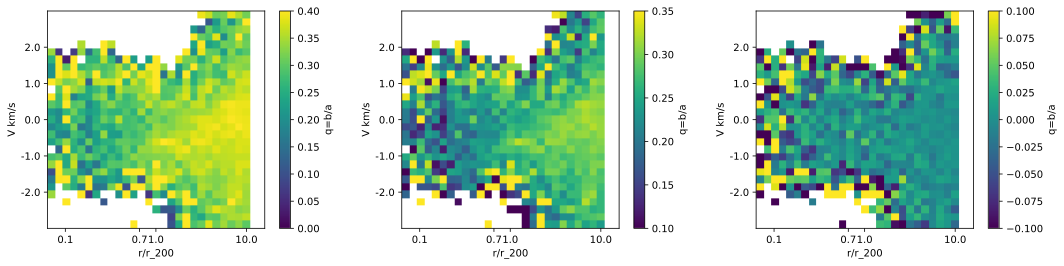

In [45]:
fig, ax = plt.subplots(1, 3, figsize = (3*6, 4), )
label = np.where(M_200>10**13/10**10)[0]
n_bin = 30
plot_v_r_2d_hist_q(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e_len[label], vmax=0.4, vmin=0., xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e1[label], vmax=0.35, vmin=0.1, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e2[label], vmax=0.1, vmin=-0.1, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])

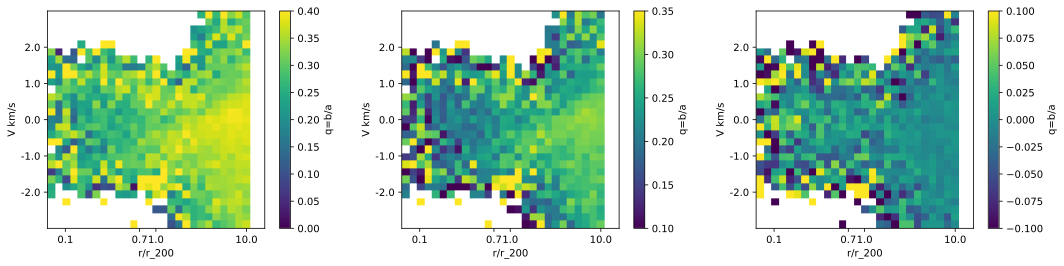

In [42]:
fig, ax = plt.subplots(1, 3, figsize = (3*6, 4), )
label = np.where(M_200>10**13/10**10)[0]
n_bin = 30
plot_v_r_2d_hist_q(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e_len[label], vmax=0.4, vmin=0., xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e1[label], vmax=0.35, vmin=0.1, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e2[label], vmax=0.1, vmin=-0.1, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])

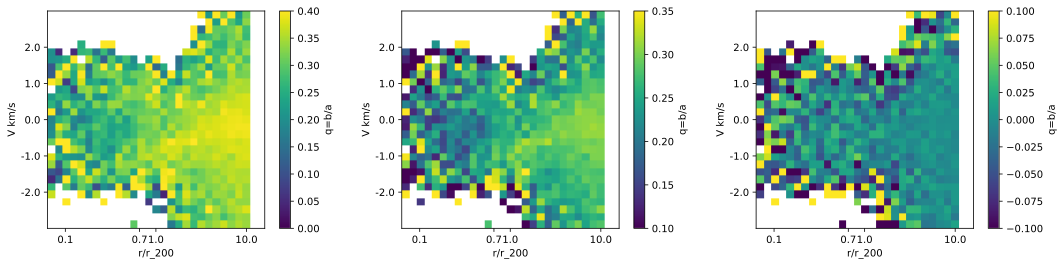

In [48]:
fig, ax = plt.subplots(1, 3, figsize = (3*6, 4), )
label = np.where(M_200>10**13/10**10)[0]
n_bin = 30
plot_v_r_2d_hist_q(ax=ax[0], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e_len[label], vmax=0.4, vmin=0., xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[1], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e1[label], vmax=0.35, vmin=0.1, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])
plot_v_r_2d_hist_q(ax=ax[2], r_bins=10**np.linspace(-1.2,1.2, n_bin), v_bins=np.linspace(-3,3,n_bin), r=r_len[label], v=v_para[label]/v_200[label], q=e2[label], vmax=0.1, vmin=-0.1, xlabel="r/r_200", ylabel="V km/s", r_ticks=[0.1, 0.66,1,10], v_ticks=[-2, -1, 0, 1, 2])

In [60]:
Group_M_Mean200[:2000]

array([35478.406   , 36520.535   , 29763.365   , ...,    83.47886 ,
          89.045494,    84.204895], dtype=float32)

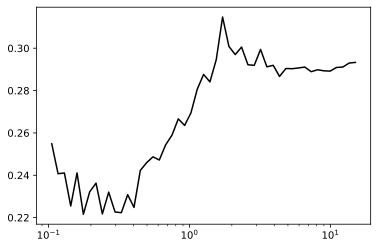

In [139]:
fig, ax =plt.subplots()
plot_histogram(ax=ax, x=(r_len/r_200), y=e1, bins=10**np.linspace(-1,1.2), c="k", label="", alpha=1)
ax.set_xscale("log")